In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import diplomatic_exchanges as de

In [23]:
# run query to get data for regression analysis from database
conn = sqlite3.connect('diplomatic.db')
data = de.get_data_for_regression(conn, 2005)

In [24]:
# use a binary variable signifying whether the US president visited each country or not
# 1: the president visited
# 0: the president did NOT visit
data['president_visit_binary'] = data['destination country'].map(lambda x: 0 if x is None else 1)

In [25]:
# example dataset
data.head(4)

,index,pagerank,betweenness,closeness,degree,in_degree,out_degreee,node_id,year,index,...,year,milex,milper,irst,pec,tpop,upop,cinc,version,president_visit_binary
0,24,1.000000,0.000730,1.0,1.000000,0.948718,1.000000,2,2005,NaN,...,2005,495326000,1474,94897,3267376,298166.0,164533.0,0.156302,2021,0
1,48,0.521256,0.035092,1.0,0.600454,0.621795,0.701754,20,2005,506.0,...,2005,13224000,62,15327,370302,32253.0,18647.0,0.010920,2021,1
2,73,0.014564,0.000009,1.0,0.014756,0.025641,0.017544,31,2005,NaN,...,2005,36000,1,0,266,329.0,0.0,0.000025,2021,0
3,1615,0.407570,0.239737,1.0,0.457435,0.564103,0.415205,40,2005,NaN,...,2005,1444000,49,245,12063,11292.0,2927.0,0.001351,2021,0


In [27]:
# dataset columns to apply PCA
columns_for_PCA = ['pagerank', 'betweenness', 'closeness', 'degree', 'in_degree', 'out_degreee']
X = data[columns_for_PCA].values

In [8]:
# eigenvalues and eigenvectors for square matrix
square = np.dot(np.transpose(X),X)
np.linalg.eig(square)

(array([2.35360109e+02, 2.67356003e+01, 1.36278176e+00, 4.09527704e-01,
        2.02222300e-02, 1.13066428e-01]),
 array([[ 0.1980397 ,  0.42202528, -0.08549149,  0.23361905, -0.38960363,
          0.7543191 ],
        [ 0.02917674,  0.03548439,  0.95822251, -0.19480931,  0.08549253,
          0.18557898],
        [ 0.88740224, -0.46001544, -0.01313597,  0.01046749,  0.00777522,
          0.02367447],
        [ 0.22775924,  0.46218364, -0.07634449,  0.16197447,  0.83633031,
          0.05476681],
        [ 0.2562887 ,  0.46066302,  0.2113814 ,  0.42606517, -0.34748556,
         -0.61249151],
        [ 0.23428208,  0.42801539, -0.15432983, -0.83641775, -0.1436836 ,
         -0.13363163]]))

We can see that the first two eigenvalues are really large compared to the rest. Therefore, we select the first two principal components.

In [29]:
# apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [31]:
# transform data to principal components
X_pca = pca.transform(X)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1','PC2'])
pca_df

,PC1,PC2
0,1.524585,-0.129111
1,0.779701,-0.046965
2,-0.407457,-0.012093
3,0.492171,0.201756
4,-0.309330,-0.019993
...,...,...
187,-0.437679,-0.011962
188,-0.397993,-0.011777
189,-0.412477,-0.050110
190,-0.417521,-0.012320


In [32]:
# add principal components to dataset
data['PC1'] = pca_df['PC1']
data['PC2'] = pca_df['PC2']

In [34]:
# compute gdp per capita
data['per_capita'] = data['rgdpna']/data['pop']
data['per_capita'].head(10)

0    54449.451941
1    45565.692084
2    35576.570576
3             NaN
4     1574.206085
5     9945.891176
6     8476.961664
7    24193.637657
8    11799.938776
9     9091.544015
Name: per_capita, dtype: float64

In [36]:
# there are some values missing from the Pennworld table dataset
sum(data["per_capita"].isna())

28

In [37]:
# we decide to drop them since they correspond to a small number of countries
data = data[data["per_capita"].notna()]
data

,index,pagerank,betweenness,closeness,degree,in_degree,out_degreee,node_id,year,index,...,irst,pec,tpop,upop,cinc,version,president_visit_binary,PC1,PC2,per_capita
0,24,1.000000,0.000730,1.0,1.000000,0.948718,1.000000,2,2005,NaN,...,94897,3267376,298166.0,164533.0,0.156302,2021,0,1.524585,-0.129111,54449.451941
1,48,0.521256,0.035092,1.0,0.600454,0.621795,0.701754,20,2005,506.0,...,15327,370302,32253.0,18647.0,0.010920,2021,1,0.779701,-0.046965,45565.692084
2,73,0.014564,0.000009,1.0,0.014756,0.025641,0.017544,31,2005,NaN,...,0,266,329.0,0.0,0.000025,2021,0,-0.407457,-0.012093,35576.570576
4,104,0.046998,0.000000,1.0,0.063564,0.070513,0.087719,41,2005,NaN,...,0,3954,9261.0,2171.0,0.000584,2021,0,-0.309330,-0.019993,1574.206085
5,147,0.136362,0.002928,1.0,0.161180,0.185897,0.157895,42,2005,NaN,...,0,6039,9343.0,2819.0,0.000820,2021,0,-0.122271,-0.018905,9945.891176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1570,0.267671,0.010502,1.0,0.312145,0.352564,0.321637,840,2005,526.0,...,470,35953,85821.0,16203.0,0.005195,2021,1,0.184685,-0.024675,4950.987895
176,1575,0.378317,0.015015,1.0,0.451759,0.480769,0.444444,850,2005,529.0,...,3675,207738,224481.0,29974.0,0.014128,2021,1,0.435790,-0.032541,6518.595408
178,1583,0.390267,0.075917,1.0,0.423383,0.442308,0.479532,900,2005,530.0,...,7757,181092,20521.0,13667.0,0.007516,2021,1,0.426349,0.013414,46135.263007
180,1591,0.178444,0.019219,1.0,0.192963,0.250000,0.175439,920,2005,NaN,...,889,20923,4134.0,1905.0,0.000915,2021,0,-0.043229,0.001428,33447.358963


In [38]:
# apply logistic regression for year 2005 using the PC1, PC2, cinc and per_capita variables
import statsmodels.formula.api as smf
log_reg_1 = smf.logit("president_visit_binary ~ PC1 + PC2 + cinc + per_capita", data=data).fit()
print(log_reg_1.summary())

Optimization terminated successfully.
         Current function value: 0.443399
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     president_visit_binary   No. Observations:                  164
Model:                              Logit   Df Residuals:                      159
Method:                               MLE   Df Model:                            4
Date:                    Sun, 26 Feb 2023   Pseudo R-squ.:                  0.2598
Time:                            00:03:32   Log-Likelihood:                -72.718
converged:                           True   LL-Null:                       -98.247
Covariance Type:                nonrobust   LLR p-value:                 2.170e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2095      0.288     -4.198      0.000      -1.774      -0.6

We can see that the coefficient for PC2 is not statistically significant while its value is also small. Therefore we exclude it from our analysis

In [39]:
# apply logistic regression to PC1, cinc and per_capita variables
log_reg_2 = smf.logit("president_visit_binary ~ PC1 + cinc + per_capita", data=data).fit()
print(log_reg_2.summary())
print(list(log_reg_2.params))
list(log_reg_2.bse)

Optimization terminated successfully.
         Current function value: 0.443660
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     president_visit_binary   No. Observations:                  164
Model:                              Logit   Df Residuals:                      160
Method:                               MLE   Df Model:                            3
Date:                    Sun, 26 Feb 2023   Pseudo R-squ.:                  0.2594
Time:                            00:04:52   Log-Likelihood:                -72.760
converged:                           True   LL-Null:                       -98.247
Covariance Type:                nonrobust   LLR p-value:                 4.957e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2044      0.288     -4.189      0.000      -1.768      -0.6

[0.28750837352983,
 0.7794748944981142,
 11.64993172705481,
 9.961531127302773e-06]

We observe that PC1 is statistically significant. We also observe that cinc is also statistically significant while per_capita is not statistically significant. This means that controlling for economic measures of status, our network-based international relations measure plays an important role in predicting a president's visits. Cinc is a variable signifying the political situation in countries which is related to international affairs.

In [139]:
regression_dict = {} 
for name_model1 in list(log_reg_1.params.index):
    print(name_model1, name_model2)
    regression_dict[f'model1_coef_{name_model1}'] = []
    regression_dict[f'model1_std_{name_model1}'] = []
    regression_dict[f'model2_coef_{name_model2}'] = []
    regression_dict[f'model2_std_{name_model2}'] = []

Intercept Intercept
PC1 PC1
PC2 cinc
cinc per_capita


In [167]:
regression_dict = {} 
models_reg1 = []
models_reg2 = []
for i in range(1970,2010,5):
    
    data = de.get_data_for_regression(conn, i)
    
    # Generate dummys
    data['president_visit_binary'] = data['destination country'].map(lambda x: 0 if x is None else 1)
    
    # Extract the columns for PCA
    columns_for_PCA = ['pagerank', 'betweenness', 'closeness', 'degree', 'in_degree', 'out_degreee']
    X = data[columns_for_PCA].values
    
    
    # Fit the principal component
    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    # Obtain the principal component and assign it to the dataset
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1','PC2'])
    data['PC1'] = pca_df['PC1']
    data['PC2'] = pca_df['PC2']
    
    # Generate the economic variable
    data['per_capita'] = data['rgdpna']/data['pop']
    
    # Drop those empty GDP per capita
    data = data[data["per_capita"].notna()]
    
    # Fit the logistic regression
    log_reg_1 = smf.logit("president_visit_binary ~ PC1 + PC2 + cinc + per_capita", data=data).fit()
    log_reg_2 = smf.logit("president_visit_binary ~ PC1 + cinc + per_capita", data=data).fit()
    
    for name1 in log_reg_1.params.index:
        regression_dict[f'model1_coef_{name1}'] = regression_dict.get(f'model1_coef_{name1}', []) + [log_reg_1.params[name1]]
        regression_dict[f'model1_std_{name1}'] = regression_dict.get(f'model1_std_{name1}', []) + [log_reg_1.bse[name1]]
    for name2 in log_reg_2.params.index:
        regression_dict[f'model2_coef_{name2}'] = regression_dict.get(f'model2_coef_{name2}', []) + [log_reg_2.params[name2]]
        regression_dict[f'model2_std_{name2}'] = regression_dict.get(f'model2_std_{name2}', []) + [log_reg_2.bse[name2]]
    
    models_reg1.append(log_reg_1)
    models_reg2.append(log_reg_2)

Optimization terminated successfully.
         Current function value: 0.445705
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335600
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.305576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.290679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.290820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341603
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341814
  

In [168]:
regression_data = pd.DataFrame(regression_dict)
regression_data['year'] = range(1970,2010,5)
regression_data

,model1_coef_Intercept,model1_std_Intercept,model1_coef_PC1,model1_std_PC1,model1_coef_PC2,model1_std_PC2,model1_coef_cinc,model1_std_cinc,model1_coef_per_capita,model1_std_per_capita,model2_coef_Intercept,model2_std_Intercept,model2_coef_PC1,model2_std_PC1,model2_coef_cinc,model2_std_cinc,model2_coef_per_capita,model2_std_per_capita,year
0,-1.284052,0.365301,2.152031,0.764954,0.054261,1.442511,-10.694687,12.723901,-0.000025,0.000032,-1.283764,0.365208,2.154970,0.760908,-10.799365,12.420160,-0.000025,0.000032,1970
1,-2.148291,0.385207,2.801284,0.665893,2.146437,2.816586,5.541199,13.814832,0.000006,0.000013,-2.138199,0.386146,2.869563,0.664689,3.045806,13.603342,0.000005,0.000013,1975
2,-2.364132,0.410888,2.979029,0.728182,-8.230732,7.913547,-12.213034,13.507230,0.000003,0.000014,-2.328038,0.402937,3.084670,0.700104,-7.533376,12.696553,0.000004,0.000014,1980
3,-2.502917,0.432640,3.304717,0.887302,0.396774,1.973640,-15.492157,15.043692,0.000011,0.000016,-2.498309,0.431833,3.292998,0.884580,-15.088421,15.030026,0.000010,0.000016,1985
4,-2.060893,0.377529,4.003720,0.904430,-0.322725,1.312833,-21.877034,13.597596,0.000011,0.000015,-2.060216,0.377199,3.995130,0.901177,-21.802530,13.557267,0.000011,0.000015,1990
5,-2.031112,0.346237,4.849342,1.001469,-2.106750,2.415563,-51.219702,18.700130,0.000024,0.000012,-2.014679,0.343392,4.783178,0.984727,-47.998207,17.081109,0.000024,0.000012,1995
6,-0.361614,0.268882,5.197988,0.914863,4.833917,4.043546,-39.862858,13.659748,-0.000007,0.000011,-0.410054,0.265828,5.109505,0.900733,-38.822421,13.878043,-0.000006,0.000011,2000
7,-1.209541,0.288152,4.088601,0.785586,-1.198676,4.104410,-30.212006,11.925281,0.000004,0.000010,-1.204379,0.287508,4.070957,0.779475,-29.642931,11.649932,0.000004,0.000010,2005


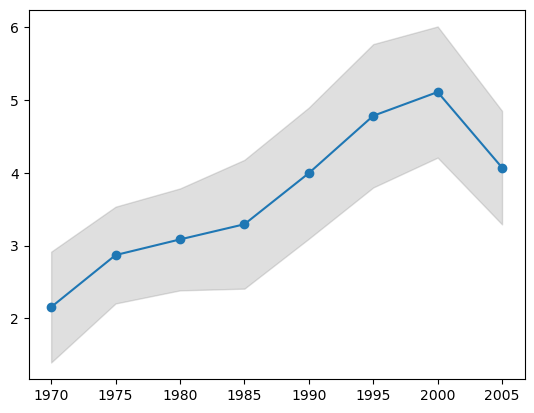

In [170]:
plt.plot(regression_data['year'], regression_data['model2_coef_PC1'], 'o-')
plt.fill_between(regression_data['year'], regression_data['model2_coef_PC1'] - regression_data['model2_std_PC1'], regression_data['model2_coef_PC1'] + regression_data['model2_std_PC1'], alpha=0.25, color='grey')

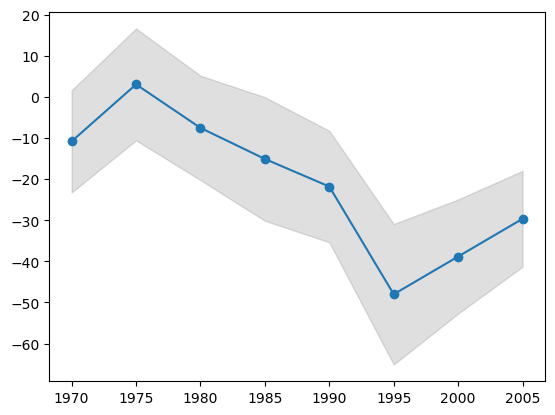

In [177]:
plt.plot(regression_data['year'], regression_data['model2_coef_cinc'], 'o-')
plt.fill_between(regression_data['year'], regression_data['model2_coef_cinc'] - regression_data['model2_std_cinc'], regression_data['model2_coef_cinc'] + regression_data['model2_std_cinc'], alpha=0.25, color='grey')

In [175]:
for model in models_reg2:
    print(model.summary())

                             Logit Regression Results                             
Dep. Variable:     president_visit_binary   No. Observations:                  118
Model:                              Logit   Df Residuals:                      114
Method:                               MLE   Df Model:                            3
Date:                    Sun, 26 Feb 2023   Pseudo R-squ.:                 0.09642
Time:                            01:06:05   Log-Likelihood:                -52.594
converged:                           True   LL-Null:                       -58.206
Covariance Type:                nonrobust   LLR p-value:                   0.01057
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2838      0.365     -3.515      0.000      -2.000      -0.568
PC1            2.1550      0.761      2.832      0.005       0.664       3.646
cinc         -10.799